# Lesson 2 - Assignment

In this assignment, you will implement a Decision Tree algorithm from scratch and compare the results to existing sklearn algorithm.

In [52]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# make this notebook's output stable across runs
np.random.seed(0)

Question 1.1: Implement the functions to calculate Gini Index.

In [53]:
# Calculate the Gini index for a split dataset
# This question is kind of confusing from a datastructures perspective
# The split point contains all the groups
# 1 - p1^2 - p2^2
def gini_index(groups, classes):
    # count all samples at split point
    samples = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size # calculate p
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / samples)
    return gini

Question 2.1: Write a method that splits the

In [54]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    """
    This function loops over each row and checks if the row belongs to the right or left list.
    Since we are using floats we just compare the values.
    """
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

Question 2.2: Write a method that loops over the dataset, determine the groups of rows that belong to the right or left split, and calculates the gini_index

In [55]:
def get_split(dataset):
    "Select the best split point for a dataset - Greedy"
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

Question 2.3: Repeat question 2.2 using entropy

In [56]:
import scipy
from scipy.stats import entropy

def get_split_entropy(dataset):
    "Select the best split point for a dataset"
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            entropy = entropy(row[index])
            if entropy < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

Question 3.1: Write a method that takes in a group of rows and determines the class they belongs to. It should return the most common output value for a list of rows.

In [57]:
def to_terminal(group):
    "determine the most commong output within each group"
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

Question 3.2: Write a method that recursively split the data.
The method takes in a node, max_depth, min_size, and depth. Initially, the method would be called by passing the rood node and depth of 1. Here are the steps to help you implement:

- First, we create two groups for the data split and delete any existing groups from the node. As rows are used, they are no longer needed.
- Second, check if rows should be in left or right group, and if so we create a terminal node using the records we have.
- Third, check if maximum depth is reached and if so we create a terminal node.
- Fourth, process left child, creating a terminal node if the group of rows is too small, otherwise creating and adding the left node in a depth first fashion until the bottom of the tree is reached on this branch.
- Fifth, process the right side in a similar manner as left side, as we rise back up the constructed tree to the root.

In [58]:
# Create child splits for a node or make terminal
# Since this is recursive we do not return any value
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    # base case #1
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    # base case #2
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

Question 3.3: Write a method that builds the tree. The method creates an initial split to determine root node, and then calls the split method.

In [59]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    "get the first split, and then split starting fromt the root"
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

Question 3.4: Write a method that takes in a node and rows of data, and predicts the class associated with each row.

In [60]:
# Make a prediction with a decision tree
def predict(node, row):
    # check if a row belongs to a node and recursively traverse the tree if the row doesn't.
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict): # check instance type, recurse
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict): # check instance type, recurse
            return predict(node['right'], row)
        else:
            return node['right']

Question 4: Train a decision tree using the banknote_authentication data

# Notes

Originally I had tried to convert the csv manually into a dataframe and append each row via the reader. This resulted in some strange behavior later on when evaluating the DT algorithm. So I switched to just manually using the lists and performing split operaitons on them and the data.

In [61]:
from random import seed
from random import randrange
from csv import reader
from sklearn.metrics import accuracy_score

def load_csv(filename):
    file = open(filename, 'rt')
    lines = reader(file)
    dataset = list(lines)
    return dataset

# Convert string column to float or integer
def str_column_to_float(dataset, column):
   for row in dataset:
      row[column] = float(row[column].strip())

filename = 'data_banknote_authentication.csv'
dataset = load_csv(filename)

# convert string attributes to integers
# I think they want floats. Integersj will lose specificity.
# Int only applies for the "target"/class
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)

train = dataset[1:int(len(dataset)*2/3)]
test = dataset[int(len(dataset)*2/3)+1:len(dataset)]

In [62]:
#Build a tree and evalute accuracy
tree = build_tree(train, 5, 10) # max_depth, min_size can be set to whatever values, I think 5 is plenty
predictions = list()
for row in test:
    prediction = predict(tree, row)
    predictions.append(prediction)
print(predictions)
print('Accuracy: %s' % accuracy_score([row[-1] for row in test], predictions))

[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

Question 5: Train and evaluate an SKLEARN decision tree model, and compare the results to your model

   variance  skewness  curtosis  entropy  class
0  -3.56370   -8.3827  12.39300 -1.28230      1
1  -3.75030  -13.4586  17.59320 -2.77710      1
2  -1.38870   -4.8773   6.47740  0.34179      1
3   0.40614    1.3492  -1.45010 -0.55949      1
4  -2.41000    3.7433  -0.40215 -1.29530      1
Accuracy: 0.9878345498783455


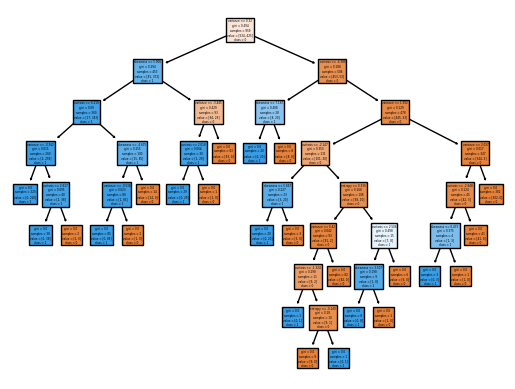

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Load a CSV file into a dataframe
# For question #5
def load_csv_dataframe(filename):
    file = filename
    with open(filename, newline='') as csvfile:
      csvreader = reader(csvfile, delimiter=',')
      df = pd.DataFrame()
      for row in csvreader:
        df = pd.concat([pd.DataFrame([row]), df], ignore_index=True)
    return df

def str_column_to_Float_dataframe(dataframe, column):
     dataframe[column] = dataframe[column].apply(pd.to_numeric)

dataframe = load_csv_dataframe(filename)

# convert string attributes to integers
# I think they want floats or integers here. Floats will lose specificity.
# Int only applies for the "target"/class
for i in range(len(dataframe.columns)):
    str_column_to_Float_dataframe(dataframe, i)

# Give the dataframe some column names
dataframe.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

df_train = dataframe[1:int(len(dataframe)*2/3)]
df_test = dataframe[int(len(dataframe)*2/3)+1:len(dataframe)]

df = pd.concat([df_train, df_test], ignore_index=True) # Just use the full dataframe
print(df.head()) # Just checking the index didn't get clobbered
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
predictions = dt_clf.predict(X_test)
predictions

print('Accuracy: %s' % accuracy_score(y_test, predictions))

# Might as well visualize it
# unfortunately we don't have great names for the columns by default so add them above!
from sklearn import tree
tree.plot_tree(dt_clf, feature_names=['variance', 'skewness', 'curtosis', 'entropy'], class_names=['0', '1'], filled=True)
plt.show()

# Quick Analysis

1. The sklearn method appears to be more accurate.
2. The sklearn model seems to have a depth of 9 and a max (valued) number of leaves at depth 5 and 6 (10 nodes each), but could potentially be much wider at those and lower depths. Perhaps more pruning would be necessary, and perhaps this tree is more 'fit' than the manual model?
3. Likely sklearn model is slower. A lot of manual methodologies that I researched during this lab (even entropy) had various optimizations that could be done outside of using the baked libs/packages.

Question 6: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: What was your incoming experience with this model, if any? what steps you took, what obstacles you encountered. how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?) This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.

# Q.6

1. I actually have some incoming experience (as I would imagine anyone who works in a computer oriented field would) given that decision trees are applicable to regular everyday occurrences and usage in computer science.
2. The steps I took were actually working in reverse - starting with question 4 and working backwards through the methods. I found that once I had the dataset configured properly I was able to work through the other methods easier since I could 'test' so to speak. Not true testing, but just looking at data.
3. I encountered a lot of obstacles in doing the calculations. I could use context clues for the recursive methodology and online resources for additional insight. However the gini and entropy calculations based on what we had eluded me until I figured out the data structure in the Ed discussion.
4. I had to learn some new libraries and figure a way to convert the manual dataset into a dataframe. Luckily I had started on this process first prior to doing it the manual way, and just reconfigured my work to fit the prompts.
5. Linking it to the real world - there's plenty of use cases for decision trees. Self driving cars, disease/healthcare prediction, cybersecurity, human behaviors...

In [64]:
%%shell
jupyter nbconvert --to html /content/Lab02.ipynb

[NbConvertApp] Converting notebook /content/Lab02.ipynb to html
[NbConvertApp] Writing 697771 bytes to /content/Lab02.html
